# Berater Environment v13

## Changes from v12 (work in progress)
* migration to easyagents

### Install gym

In [1]:
!pip install gym==0.10.11 > /dev/null

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


# Define Gym Environment

### Imports

In [13]:
import numpy as np
import random

import gym
from gym.utils import seeding
from gym import spaces

import pdb

### Helper methods

In [14]:
def state_name_to_int(state):
    state_name_map = {
        'S': 0,
        'A': 1,
        'B': 2,
        'C': 3,
        'D': 4,
        'E': 5,
        'F': 6,
        'G': 7,
        'H': 8,
        'K': 9,
        'L': 10,
        'M': 11,
        'N': 12,
        'O': 13
    }
    return state_name_map[state]

def int_to_state_name(state_as_int):
    state_map = {
        0: 'S',
        1: 'A',
        2: 'B',
        3: 'C',
        4: 'D',
        5: 'E',
        6: 'F',
        7: 'G',
        8: 'H',
        9: 'K',
        10: 'L',
        11: 'M',
        12: 'N',
        13: 'O'
    }
    return state_map[state_as_int]
    


### Berater Environment (OpenAI Gym)

In [15]:
class BeraterEnv(gym.Env):
    """
    The Berater Problem

    Actions: 
    There are 4 discrete deterministic actions, each choosing one direction
    """
    metadata = {'render.modes': ['ansi']}
    
    showStep = False
    showDone = True
    envEpisodeModulo = 100

    def __init__(self):
#         self.map = {
#             'S': [('A', 100), ('B', 400), ('C', 200 )],
#             'A': [('B', 250), ('C', 400), ('S', 100 )],
#             'B': [('A', 250), ('C', 250), ('S', 400 )],
#             'C': [('A', 400), ('B', 250), ('S', 200 )]
#         }
        self.map = {
            'S': [('A', 300), ('B', 100), ('C', 200 )],
            'A': [('S', 300), ('B', 100), ('E', 100 ), ('D', 100 )],
            'B': [('S', 100), ('A', 100), ('C', 50 ), ('K', 200 )],
            'C': [('S', 200), ('B', 50), ('M', 100 ), ('L', 200 )],
            'D': [('A', 100), ('F', 50)],
            'E': [('A', 100), ('F', 100), ('H', 100)],
            'F': [('D', 50), ('E', 100), ('G', 200)],
            'G': [('F', 200), ('O', 300)],
            'H': [('E', 100), ('K', 300)],
            'K': [('B', 200), ('H', 300)],
            'L': [('C', 200), ('M', 50)],
            'M': [('C', 100), ('L', 50), ('N', 100)],
            'N': [('M', 100), ('O', 100)],
            'O': [('N', 100), ('G', 300)]
        }
        max_paths = 4
        self.action_space = spaces.Discrete(max_paths)
      
        positions = len(self.map)
        # observations: position, reward of all 4 local paths, rest reward of all locations
        # non existing path is -1000 and no position change
        # look at what #getObservation returns if you are confused
        low = np.append(np.append([0], np.full(max_paths, -1000)), np.full(positions, 0))
        high = np.append(np.append([positions - 1], np.full(max_paths, 1000)), np.full(positions, 1000))
        self.observation_space = spaces.Box(low=low,
                                             high=high,
                                             dtype=np.float32)
        self.reward_range = (-1, 1)

        self.totalReward = 0
        self.stepCount = 0
        self.isDone = False

        self.envReward = 0
        self.envEpisodeCount = 0
        self.envStepCount = 0

        self.reset()
        self.optimum = self.calculate_customers_reward()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def iterate_path(self, state, action):
        paths = self.map[state]
        if action < len(paths):
          return paths[action]
        else:
          # sorry, no such action, stay where you are and pay a high penalty
          return (state, 1000)
      
    def step(self, action):
        if self.debugStep:
          pdb.set_trace()
        destination, cost = self.iterate_path(self.state, action)
        lastState = self.state
        customerReward = self.customer_reward[destination]
        reward = (customerReward - cost) / self.optimum

        self.state = destination
        self.customer_visited(destination)
        done = (destination == 'S' and self.all_customers_visited())
        if self.stepCount >= 200:
          if BeraterEnv.showDone:
            print("Done: stepCount >= 200")
          done = True

        stateAsInt = state_name_to_int(self.state)
        self.totalReward += reward
        self.stepCount += 1
        self.envReward += reward
        self.envStepCount += 1

        if self.showStep:
            print( "Episode: " + ("%4.0f  " % self.envEpisodeCount) + 
                   " Step: " + ("%4.0f  " % self.stepCount) + 
                   lastState + ' --' + str(action) + '-> ' + self.state + 
                   ' R=' + ("% 2.2f" % reward) + ' totalR=' + ("% 3.2f" % self.totalReward) + 
                   ' cost=' + ("%4.0f" % cost) + ' customerR=' + ("%4.0f" % customerReward) + ' optimum=' + ("%4.0f" % self.optimum)      
                   )

        if done and not self.isDone:
            self.envEpisodeCount += 1
            if BeraterEnv.showDone:
                episodes = BeraterEnv.envEpisodeModulo
                if (self.envEpisodeCount % BeraterEnv.envEpisodeModulo != 0):
                    episodes = self.envEpisodeCount % BeraterEnv.envEpisodeModulo
                print( "Done: " + 
                        ("episodes=%6.0f  " % self.envEpisodeCount) + 
                        ("avgSteps=%6.2f  " % (self.envStepCount/episodes)) + 
                        ("avgTotalReward=% 3.2f" % (self.envReward/episodes) )
                        )
                if (self.envEpisodeCount%BeraterEnv.envEpisodeModulo) == 0:
                    self.envReward = 0
                    self.envStepCount = 0

        self.isDone = done
        observation = self.getObservation(stateAsInt)
        info = {"from": self.state, "to": destination}

        return observation, reward, done, info

    def getObservation(self, position):
        result = np.array([ position, 
                               self.getPathObservation(position, 0),
                               self.getPathObservation(position, 1),
                               self.getPathObservation(position, 2),
                               self.getPathObservation(position, 3)
                              ],
                             dtype=np.float32)
        all_rest_rewards = list(self.customer_reward.values())
        result = np.append(result, all_rest_rewards)
        return result

    def getPathObservation(self, position, path):
        source = int_to_state_name(position)
        paths = self.map[self.state]
        if path < len(paths):
          target, cost = paths[path]
          reward = self.customer_reward[target] 
          result = reward - cost
        else:
          result = -1000

        return result

    def customer_visited(self, customer):
        self.customer_reward[customer] = 0

    def all_customers_visited(self):
        return self.calculate_customers_reward() == 0

    def calculate_customers_reward(self):
        sum = 0
        for value in self.customer_reward.values():
            sum += value
        return sum

      
    def modulate_reward(self):
      number_of_customers = len(self.map) - 1
      number_per_consultant = int(number_of_customers/2)
#       number_per_consultant = int(number_of_customers/1.5)
      self.customer_reward = {
          'S': 0
      }
      for customer_nr in range(1, number_of_customers + 1):
        self.customer_reward[int_to_state_name(customer_nr)] = 0
      
      # every consultant only visits a few random customers
      samples = random.sample(range(1, number_of_customers + 1), k=number_per_consultant)
      key_list = list(self.customer_reward.keys())
      for sample in samples:
        self.customer_reward[key_list[sample]] = 1000

      
    def reset(self):
        self.totalReward = 0
        self.stepCount = 0
        self.isDone = False

        self.modulate_reward()
        self.state = 'S'
        return self.getObservation(state_name_to_int(self.state))
      
    def render(self):
      print(self.customer_reward)

In [16]:
BeraterEnv.showStep = False
BeraterEnv.showDone = False
BeraterEnv.debugStep = False

### Register with OpenAI Gym

In [17]:
if not 'isEnvRegistered' in locals():
  env_name="Berater-v1"
  gym.envs.registration.register(id=env_name,entry_point=BeraterEnv,max_episode_steps=1000)
  isEnvRegistered=True
  print("Berater registered as '" + env_name + "'")
else:
  print("Already registered")

Already registered


# Train policy with tfagents PpoAgent

## Install

In [18]:
!pip install easyagents > /dev/null

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [19]:
#!pip install -i https://test.pypi.org/simple/ easyagents > /dev/null

## 1. Dry run (very short, no logging)

In [20]:
from easyagents.tfagents import PpoAgent
from easyagents.config import TrainingDurationFast
from easyagents.config import LoggingSilent

In [21]:
ppoAgent = PpoAgent(    gym_env_name = 'Berater-v1',
                        training_duration=TrainingDurationFast(),
                        logging = LoggingSilent() )
ppoAgent.train()

### Visualize

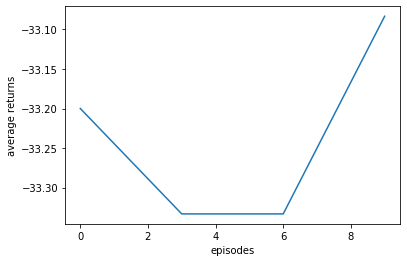

In [22]:
ppoAgent.plot_average_returns()

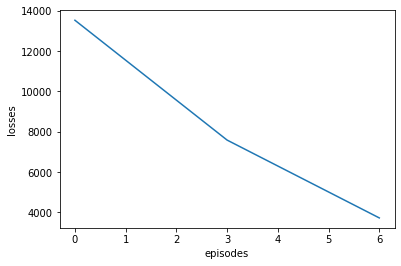

In [23]:
ppoAgent.plot_losses()

## 2. Short training (with chosen policy network layers, training durations & default logging)

In [24]:
from easyagents.tfagents import PpoAgent
from easyagents.config import TrainingDuration

In [25]:
training_duration=TrainingDuration( num_iterations = 50,
                                    num_episodes_per_iteration = 10,
                                    max_steps_per_episode = 1000,
                                    num_epochs_per_iteration = 5,
                                    num_iterations_between_eval = 10,
                                    num_eval_episodes = 10 )

In [27]:
ppoAgent = PpoAgent(    gym_env_name = 'Berater-v1',
                        fc_layers=(500,500,500), 
                        training_duration=training_duration )
ppoAgent.train()

I0626 21:55:31.814436 12772 agents.py:60] gym_env_name=Berater-v1 fc_layers=(500, 500, 500)
I0626 21:55:31.815778 12772 agents.py:69] executing: tf.compat.v1.enable_v2_behavior()
I0626 21:55:31.816433 12772 agents.py:69] executing: tf.enable_eager_execution()
I0626 21:55:31.817433 12772 agents.py:69] executing: tf.compat.v1.set_random_seed(0)
I0626 21:55:31.828431 12772 agents.py:69] Creating environment:
I0626 21:55:31.829433 12772 agents.py:69]    executing tf_py_environment.TFPyEnvironment( suite_gym.load )
I0626 21:55:31.848441 12772 agents.py:69] Creating agent:
I0626 21:55:31.849441 12772 agents.py:69]   creating  tf.compat.v1.train.AdamOptimizer( ... )
I0626 21:55:31.862470 12772 agents.py:69]   creating  PPOAgent( ... )
I0626 21:55:31.879480 12772 agents.py:69]   executing tf_agent.initialize()
I0626 21:55:31.881434 12772 agents.py:69] Creating data collection:
I0626 21:55:31.883462 12772 agents.py:69]   creating TFUniformReplayBuffer()
I0626 21:55:31.902435 12772 agents.py:69]

I0626 21:56:19.014696 17180 logenv.py:75] #0  52.162 [R= -13.8] game over
I0626 21:56:19.072192 17180 logenv.py:75] #0  53.85  [R=  -3.9] game over
I0626 21:56:19.151181 17180 logenv.py:75] #0  54.100 [R=  -4.3] game over
I0626 21:56:19.159415 12772 agents.py:69] training 5 of 50: executing replay_buffer.gather_all()
I0626 21:56:19.162410 12772 agents.py:69] training 5 of 50: executing tf_agent.train(...)
I0626 21:56:20.582983 12772 agents.py:69] training 5 of 50: completed tf_agent.train(...) = 1658.831 [loss]
I0626 21:56:20.584200 12772 agents.py:69] training 5 of 50: executing replay_buffer.clear()
I0626 21:56:20.584983 12772 agents.py:69] training 6 of 50: executing collect_driver.run()
I0626 21:56:20.585985  5292 logenv.py:75] #0  55.0   [R=   0.0] executing reset(...)
I0626 21:56:20.708983  7092 logenv.py:75] #0  56.197 [R= -12.9] game over
I0626 21:56:20.822090  7092 logenv.py:75] #0  57.201 [R= -14.0] game over
I0626 21:56:20.877991  7092 logenv.py:75] #0  58.94  [R=  -5.8] gam

I0626 21:56:45.292976  5292 logenv.py:75] #0 111.117 [R=  -3.9] game over
I0626 21:56:45.403972  5292 logenv.py:75] #0 112.192 [R=  -4.4] game over
I0626 21:56:45.492792  5292 logenv.py:75] #0 113.156 [R=  -4.3] game over
I0626 21:56:45.551025  5292 logenv.py:75] #0 114.84  [R=  -2.1] game over
I0626 21:56:45.576712  5292 logenv.py:75] #0 115.41  [R=  -0.9] game over
I0626 21:56:45.656719  5292 logenv.py:75] #0 116.138 [R=  -3.7] game over
I0626 21:56:45.684289  5292 logenv.py:75] #0 117.39  [R=  -0.7] game over
I0626 21:56:45.732401  5292 logenv.py:75] #0 118.79  [R=  -2.3] game over
I0626 21:56:45.852010  5292 logenv.py:75] #0 119.201 [R=  -5.7] game over
I0626 21:56:45.870047  5292 logenv.py:75] #0 120.26  [R=  -0.1] game over
I0626 21:56:45.876016 12772 agents.py:69] training 11 of 50: executing replay_buffer.gather_all()
I0626 21:56:45.879020 12772 agents.py:69] training 11 of 50: executing tf_agent.train(...)
I0626 21:56:47.324054 12772 agents.py:69] training 11 of 50: completed 

I0626 21:56:59.548985 17500 logenv.py:75] #0 182.57  [R=  -0.3] game over
I0626 21:56:59.585175 17500 logenv.py:75] #0 183.53  [R=  -0.3] game over
I0626 21:56:59.625078 17500 logenv.py:75] #0 184.55  [R=  -0.5] game over
I0626 21:56:59.679160 17500 logenv.py:75] #0 185.81  [R=  -1.9] game over
I0626 21:56:59.711414 17500 logenv.py:75] #0 186.47  [R=  -0.1] game over
I0626 21:56:59.717171 12772 agents.py:69] training 17 of 50: executing replay_buffer.gather_all()
I0626 21:56:59.721122 12772 agents.py:69] training 17 of 50: executing tf_agent.train(...)
I0626 21:57:01.216181 12772 agents.py:69] training 17 of 50: completed tf_agent.train(...) = 176.472 [loss]
I0626 21:57:01.218185 12772 agents.py:69] training 17 of 50: executing replay_buffer.clear()
I0626 21:57:01.220180 12772 agents.py:69] training 18 of 50: executing collect_driver.run()
I0626 21:57:01.222183 10184 logenv.py:75] #0 187.0   [R=   0.0] executing reset(...)
I0626 21:57:01.280802 10184 logenv.py:75] #0 188.54  [R=  -0.5]

I0626 21:57:22.680741 12772 agents.py:69] training 23 of 50: executing collect_driver.run()
I0626 21:57:22.682906 10184 logenv.py:75] #0 242.0   [R=   0.0] executing reset(...)
I0626 21:57:22.709786 10184 logenv.py:75] #0 243.31  [R=   0.4] game over
I0626 21:57:22.731740 10184 logenv.py:75] #0 244.24  [R=   0.4] game over
I0626 21:57:22.761740 10184 logenv.py:75] #0 245.40  [R=  -0.6] game over
I0626 21:57:22.784744 10184 logenv.py:75] #0 246.30  [R=   0.2] game over
I0626 21:57:22.817740 10184 logenv.py:75] #0 247.37  [R=   0.2] game over
I0626 21:57:22.850165 10184 logenv.py:75] #0 248.44  [R=   0.0] game over
I0626 21:57:22.868094 10184 logenv.py:75] #0 249.20  [R=   0.6] game over
I0626 21:57:22.913755 10184 logenv.py:75] #0 250.61  [R=  -0.2] game over
I0626 21:57:22.941400 10184 logenv.py:75] #0 251.35  [R=   0.4] game over
I0626 21:57:22.971271 10184 logenv.py:75] #0 252.35  [R=  -0.1] game over
I0626 21:57:22.977359 12772 agents.py:69] training 23 of 50: executing replay_buffe

I0626 21:57:33.467038  5292 logenv.py:75] #0 312.40  [R=   0.1] game over
I0626 21:57:33.491038  5292 logenv.py:75] #0 313.19  [R=   0.5] game over
I0626 21:57:33.507117  5292 logenv.py:75] #0 314.18  [R=   0.6] game over
I0626 21:57:33.542924  5292 logenv.py:75] #0 315.37  [R=   0.1] game over
I0626 21:57:33.560215  5292 logenv.py:75] #0 316.15  [R=   0.6] game over
I0626 21:57:33.580464  5292 logenv.py:75] #0 317.21  [R=   0.6] game over
I0626 21:57:33.618464  5292 logenv.py:75] #0 318.29  [R=   0.4] game over
I0626 21:57:33.626199 12772 agents.py:69] training 29 of 50: executing replay_buffer.gather_all()
I0626 21:57:33.630106 12772 agents.py:69] training 29 of 50: executing tf_agent.train(...)
I0626 21:57:35.409479 12772 agents.py:69] training 29 of 50: completed tf_agent.train(...) = 52.842 [loss]
I0626 21:57:35.410477 12772 agents.py:69] training 29 of 50: executing replay_buffer.clear()
I0626 21:57:35.411477 12772 agents.py:69] training 30 of 50: executing collect_driver.run()
I

I0626 21:57:51.908434 12772 agents.py:69] training 34 of 50: executing replay_buffer.clear()
I0626 21:57:51.910434 12772 agents.py:69] training 35 of 50: executing collect_driver.run()
I0626 21:57:51.911440 10184 logenv.py:75] #0 374.0   [R=   0.0] executing reset(...)
I0626 21:57:51.947437 10184 logenv.py:75] #0 375.53  [R=  -0.2] game over
I0626 21:57:51.961589 10184 logenv.py:75] #0 376.18  [R=   0.6] game over
I0626 21:57:51.975592 10184 logenv.py:75] #0 377.15  [R=   0.7] game over
I0626 21:57:52.007985 10184 logenv.py:75] #0 378.49  [R=  -0.0] game over
I0626 21:57:52.053587 10184 logenv.py:75] #0 379.44  [R=  -0.1] game over
I0626 21:57:52.112339 10184 logenv.py:75] #0 380.80  [R=  -0.4] game over
I0626 21:57:52.130111 10184 logenv.py:75] #0 381.18  [R=   0.6] game over
I0626 21:57:52.154790 10184 logenv.py:75] #0 382.31  [R=   0.5] game over
I0626 21:57:52.175053 10184 logenv.py:75] #0 383.22  [R=   0.6] game over
I0626 21:57:52.194803 10184 logenv.py:75] #0 384.19  [R=   0.6] 

I0626 21:58:03.809182 12772 logenv.py:75] #1  44.14  [R=   0.6] game over
I0626 21:58:04.784944 12772 logenv.py:75] #1  45.201 [R=  -1.4] game over
I0626 21:58:04.845947 12772 logenv.py:75] #1  46.13  [R=   0.7] game over
I0626 21:58:06.336557 12772 logenv.py:75] #1  47.201 [R=  -2.6] game over
I0626 21:58:07.335880 12772 logenv.py:75] #1  48.201 [R=  -1.4] game over
I0626 21:58:08.307960 12772 logenv.py:75] #1  49.201 [R=  -2.7] game over
I0626 21:58:09.230682 12772 logenv.py:75] #1  50.201 [R=  -2.8] game over
I0626 21:58:09.231681 12772 agents.py:69] completed compute_avg_return(...) = -1.553
I0626 21:58:09.232680 12772 agents.py:69] training 41 of 50: executing collect_driver.run()
I0626 21:58:09.235687  5292 logenv.py:75] #0 440.0   [R=   0.0] executing reset(...)
I0626 21:58:09.318962  5292 logenv.py:75] #0 441.117 [R=  -1.2] game over
I0626 21:58:09.336671  5292 logenv.py:75] #0 442.22  [R=   0.6] game over
I0626 21:58:09.355924  5292 logenv.py:75] #0 443.22  [R=   0.6] game ove

I0626 21:58:18.093643 12772 agents.py:69] training 46 of 50: completed tf_agent.train(...) = 122.134 [loss]
I0626 21:58:18.094641 12772 agents.py:69] training 46 of 50: executing replay_buffer.clear()
I0626 21:58:18.095645 12772 agents.py:69] training 47 of 50: executing collect_driver.run()
I0626 21:58:18.097708 17180 logenv.py:75] #0 506.0   [R=   0.0] executing reset(...)
I0626 21:58:18.110642 17180 logenv.py:75] #0 507.16  [R=   0.7] game over
I0626 21:58:18.142179 17180 logenv.py:75] #0 508.47  [R=  -0.4] game over
I0626 21:58:18.156644 17180 logenv.py:75] #0 509.15  [R=   0.7] game over
I0626 21:58:18.169642 17180 logenv.py:75] #0 510.14  [R=   0.7] game over
I0626 21:58:18.186644 17180 logenv.py:75] #0 511.22  [R=   0.5] game over
I0626 21:58:18.201713 17180 logenv.py:75] #0 512.12  [R=   0.8] game over
I0626 21:58:18.222710 17180 logenv.py:75] #0 513.22  [R=   0.5] game over
I0626 21:58:18.244711 17180 logenv.py:75] #0 514.31  [R=   0.3] game over
I0626 21:58:18.275774 17180 lo

### Visualize

In [ ]:
ppoAgent.plot_average_returns()

In [ ]:
ppoAgent.plot_losses()

## 3. Full training (full duration, learning rate, reduced logging)

In [ ]:
from easyagents.tfagents import PpoAgent
from easyagents.config import TrainingDuration
from easyagents.config import Logging

In [ ]:
training_duration=TrainingDuration( num_iterations = 2000,
                                    num_episodes_per_iteration = 10,
                                    max_steps_per_episode = 1000,
                                    num_epochs_per_iteration = 5,
                                    num_iterations_between_eval = 10,
                                    num_eval_episodes = 10 )

In [ ]:
logging=Logging(log_agent=True, log_gym_env=False)

In [ ]:
ppoAgent = PpoAgent(    gym_env_name = 'Berater-v1',
                        fc_layers=(500,500,500), 
                        training_duration=training_duration,
                        logging=logging,
                        learning_rate=1e-4
                   )
ppoAgent.train()

### Visualize

In [ ]:
ppoAgent.plot_average_returns()

In [ ]:
ppoAgent.plot_losses()